## Testing a new attempt to integrate Tobin's classification with radar data

Combine Tobin with Steiner and see if the results still make sense on the scales of radar data.

In [66]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
%matplotlib inline
import time
from copy import deepcopy
import math

## Test case 1 - MCS Dec 24 2005 13Z

In [37]:
radar_mcs_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20051224130000ppi.nc'
radar_mcs = pyart.io.read(radar_mcs_path)

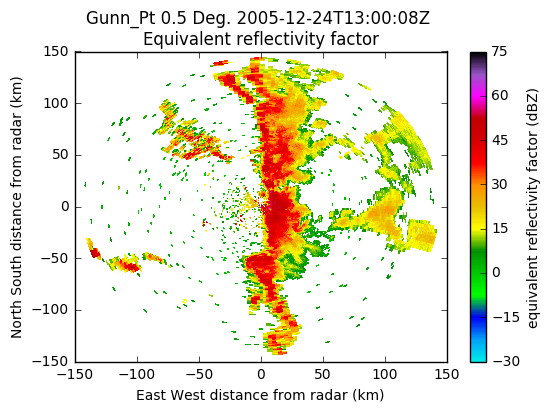

In [47]:
gatefilter = pyart.filters.GateFilter(radar_mcs)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
gatefilter.exclude_below('reflectivity',0)
display_mcs = pyart.graph.RadarMapDisplay(radar_mcs)
display_mcs.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [39]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Cressman',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb,
        gatefilter=gatefilter)
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [44]:
grid_mcs = grid_radar(radar_mcs, 
                       origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                       xlim=(-150000, 150000), ylim=(-150000, 150000), 
                       fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                       h_factor=2.0,
                       zlim=(500, 20000), grid_shape=(40, 121, 121),
                       gatefilter=gatefilter)

1.090538501739502 seconds to grid radar


N = 20


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


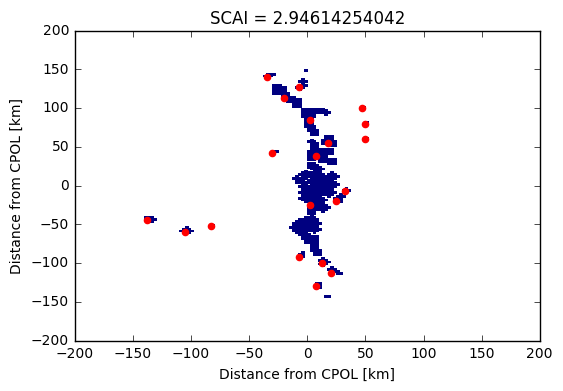

In [85]:
convective = pyart.retrieve.steiner_conv_strat(grid_mcs)
x,y = np.meshgrid(grid_mcs.x['data'], grid_mcs.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))

## Test case 2 - March 5 2006 (disorganized) 1210Z

In [77]:
radar_dis_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20060305121000ppi.nc'
radar_dis = pyart.io.read(radar_dis_path)

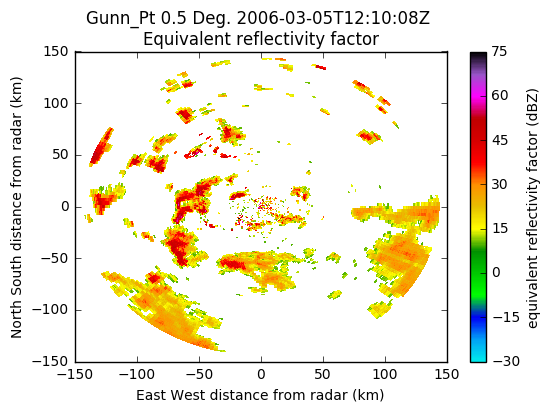

In [81]:
gatefilter = pyart.filters.GateFilter(radar_dis)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
gatefilter.exclude_below('reflectivity',10)
display_dis = pyart.graph.RadarMapDisplay(radar_dis)
display_dis.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [82]:
grid_dis = grid_radar(radar_dis, 
                      origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                      xlim=(-150000, 150000), ylim=(-150000, 150000), 
                      fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                      h_factor=2.0,
                      zlim=(500, 20000), grid_shape=(40, 121, 121),
                      gatefilter=gatefilter)

1.092625617980957 seconds to grid radar


N = 54


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


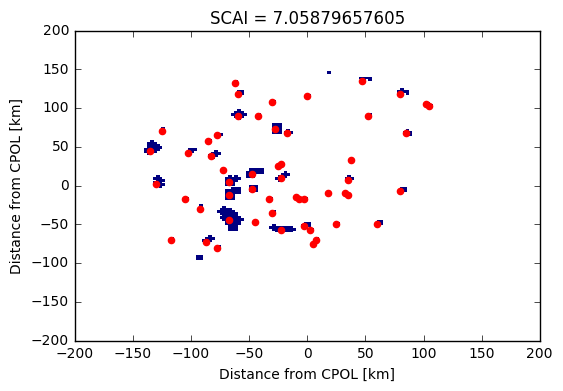

In [84]:
convective = pyart.retrieve.steiner_conv_strat(grid_dis)
x,y = np.meshgrid(grid_dis.x['data'], grid_dis.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))

## Test case 3 - Two lines + few cells 2-4-2007 550Z

In [90]:
radar_ns_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20070204055000ppi.nc'
radar_ns = pyart.io.read(radar_ns_path)

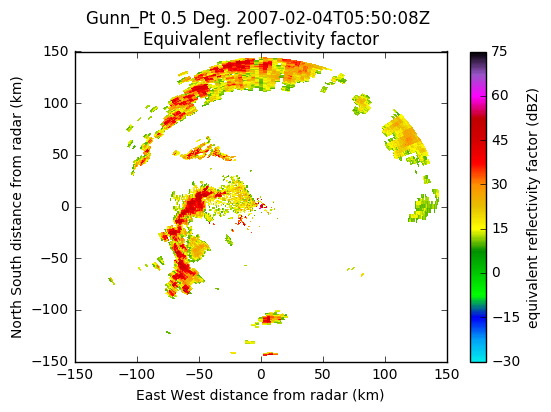

In [92]:
gatefilter = pyart.filters.GateFilter(radar_ns)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
gatefilter.exclude_below('reflectivity',10)
display_ns = pyart.graph.RadarMapDisplay(radar_ns)
display_ns.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [93]:
grid_ns = grid_radar(radar_ns, 
                     origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                     xlim=(-150000, 150000), ylim=(-150000, 150000), 
                     fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                     h_factor=2.0,
                     zlim=(500, 20000), grid_shape=(40, 121, 121),
                     gatefilter=gatefilter)

1.5651555061340332 seconds to grid radar


N = 24


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


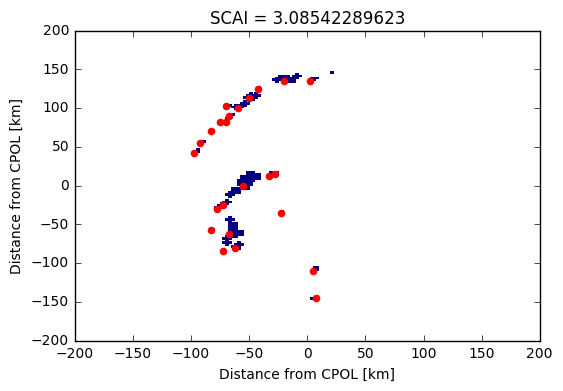

In [94]:
convective = pyart.retrieve.steiner_conv_strat(grid_ns)
x,y = np.meshgrid(grid_ns.x['data'], grid_ns.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))

## March 24 2007 420Z -- scattered showers

In [95]:
radar_ss_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20070324042000ppi.nc'
radar_ss = pyart.io.read(radar_ss_path)

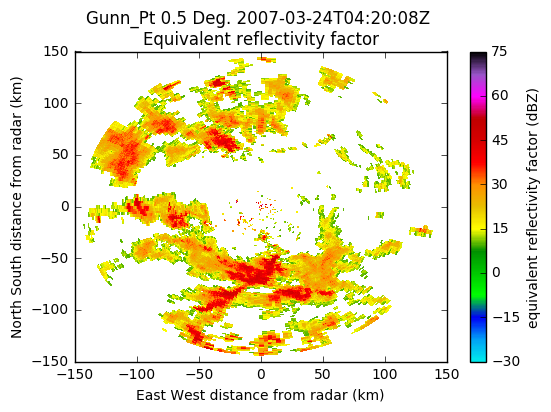

In [96]:
gatefilter = pyart.filters.GateFilter(radar_ss)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
gatefilter.exclude_below('reflectivity',10)
display_ss = pyart.graph.RadarMapDisplay(radar_ss)
display_ss.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [97]:
grid_ss = grid_radar(radar_ss, 
                     origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                     xlim=(-150000, 150000), ylim=(-150000, 150000), 
                     fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                     h_factor=2.0,
                     zlim=(500, 20000), grid_shape=(40, 121, 121),
                     gatefilter=gatefilter)

1.6011841297149658 seconds to grid radar


N = 47


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


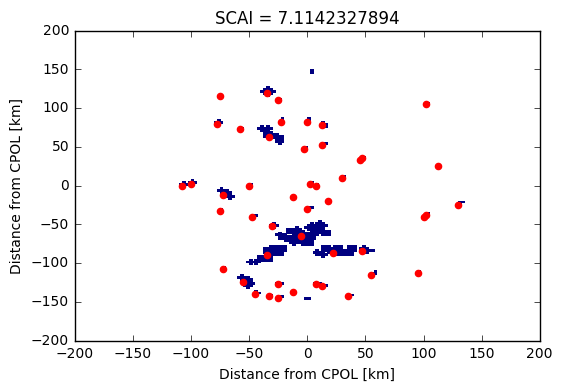

In [98]:
convective = pyart.retrieve.steiner_conv_strat(grid_ss)
x,y = np.meshgrid(grid_ss.x['data'], grid_ss.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))